#### Practical strategies for ships passing limited water depth to achieve multiple goals
- Strategies include vessel sailing velocities, payload adjustment(actual draught), parcial engine load
- multiple goals covers the indicators of fuel use, emissions (CO2, PM10, NOx), transport time, safefy (represented by the remaining space between ship bottom and the bed of the waterway). 

##### Steps
- present a waterway section with limited water depth (150 km with 2.5 m water depth) on the graph
- provide a list of feasible draughts according to vessel size, water depth and safety margin (minimum ukc) prevent grounding
- use get_v funtion to get maximum feasible velocity considering both installed enegine power and ship squat while moving at a speed
- for each possible T&V combination, incorporate energy module, output a table with results of all the indicators
- use 'Parallel coordinate plot' to visualise strategies
- Automatically select optimal strategies to achieve the goal of less transport time, less emissions, less fuel use, safety guarantees.

In [1]:

# spatial libraries
import shapely.geometry
import pyproj

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt
import requests
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go

import functools
import itertools
import warnings
warnings.filterwarnings('ignore')
import sys
sys.tracebacklimit=0
# package(s) related to time, space and id
import logging
import datetime, time
import platform

# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling

import scipy.optimize
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import tqdm

# Used for mathematical functions
import math             

import plotly.express as px
from plotly.subplots import make_subplots

#logging.basicConfig(level=logging.DEBUG) #turn on all the debug messages
#logging.basicConfig(level=logging.INFO)# turn off all the debug messages

logger = logging.getLogger('notebook')

# Used for making the graph
import networkx as nx

# OpenTNSim
import opentnsim


#### Present the waterway section with limited water depth on the graph network

In [2]:
# We're in engineering cordinates (m)
coords = [
    [0,0],
    [8.983,0], 
    [17.966,0],
    [17.966,13.566],
    [17.966,22.609],
    [27.527,9.560],
    [33.903,15.931],
    [31.441,0],
    
    [40.424, 0],
    [19.560,-01.693],
    [33.904,-15.931]] 


# these are the indices of the points above
edge_indices = [
    [0, 1],
    [1, 2],
    [2, 3],
    [3, 4],
    [2, 5],
    [5, 6],
    [2, 7],
    [7, 8],
    [2, 9],
    [9, 10]   
]

depths = [12.5, 6, 6, 6, 4.5, 6, 2.5, 6, 2.5, 6] 

widths = [300, 150, 150, 150, 150, 150, 150, 150, 150, 150]

points = [
    shapely.geometry.Point(*coord )
    for coord 
    in coords
]

In [3]:
# define Site class
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

In [4]:
FG = nx.DiGraph()

nodes = []
for index, coord in enumerate(coords):
    data_node = {"name": str(index), "geometry": shapely.geometry.Point(points[index].x, points[index].y)}
    nodes.append(Node(**data_node))

for node in nodes:
    FG.add_node(node.name, geometry = node.geometry)    
    
for index, edge in enumerate(edge_indices):
    edge_geometry = shapely.geometry.LineString([points[edge[0]], points[edge[1]]])
    edge_properties = dict(
        GeneralDepth = depths[index],
        width = widths[index],
        geometry = edge_geometry, 
        length = round(edge_geometry.length),
        e = tuple(edge)
    )
    FG.add_edge( str(edge[0]), str(edge[1]), weight = 1, Info = edge_properties)

# toggle to undirected and back to directed to make sure all edges are two way traffic
FG = FG.to_undirected() 
FG = FG.to_directed() 

In [5]:
positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)

In [6]:
# collect node labels.
labels = {}
for node in FG.nodes:
    labels[node] = node

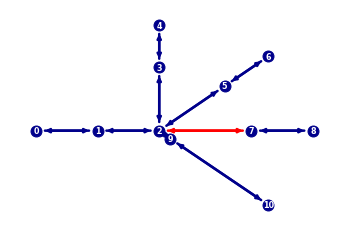

In [7]:
# draw edges, nodes and labels.
colors =['darkblue','darkblue','darkblue','darkblue','darkblue','darkblue','r','darkblue','darkblue','darkblue','darkblue','darkblue','darkblue','darkblue','r','darkblue','darkblue','darkblue','darkblue','darkblue']
nx.draw_networkx_edges(FG,  pos=positions, width=2.5, edge_color=colors, alpha=1, arrowsize=8)
nx.draw_networkx_nodes(FG,  pos=positions, node_color="darkblue", node_size=120)
nx.draw_networkx_labels(FG, pos=positions, labels=labels, font_size=8, font_weight='bold', font_color="white")

plt.axis("off")
plt.savefig('graph_limited_water_dpeth.pdf', bbox_inches = 'tight', dpi=600, format='pdf') 
plt.show()

#### Create vessel - add VesselProperties and ConsumesEnergy mixins

In [8]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.Routeable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.energy.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

In [9]:
# Create a dict with all important settings
data_vessel = {
               "env": None,
               "name": None,
               "route": None,
               "geometry": None,
               "v": None,  # m/s
               "type":  None, # <-- note that inputs from hereon are due to the added mixins!
               "B": 11.4,
               "L": 110,
               "H_e": None, 
               "H_f": None, 
               "T": 2.05,
               "safety_margin": 0.2, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
               "h_squat":True,
               "P_installed": 1750.0,   
               "P_tot_given": None, # kW
               "bulbous_bow": False, # if a vessel has no bulbous_bow, set to none; otherwise set to 1.
               "P_hotel_perc": 0.05,
               "P_hotel": None, # None: calculate P_hotel from percentage
               "x": 2,# number of propellers
               "L_w": 3.0 ,
               "C_B":0.85, 
               "C_year":1990,
              }        
data_vessel_i = data_vessel.copy()
vessel = TransportResource(**data_vessel_i)

In [10]:
draught = opentnsim.strategy.Payload2T(vessel= vessel, Payload_strategy=1056, vessel_type= "Tanker")
draught 

AttributeError: module 'opentnsim.strategy' has no attribute 'Payload2T'

#### Provide a group of feasible draughts according to vessel size, water depth and safety margin (minimum ukc) prevent grounding
here we choose M8 vessel as it has a large share of the sailing movements per year on waal (Rijkswaterstaat,2021, Safety aspects of new energy carriers in inland navigation), M8's draught ranges from 1.4 m to 3.5 m, considering a safety margin (minimum ukc) of 0.2 m at water depth 2.5 m, the final feasible draught ranges from 1.4 m to 2.3 m.

In [ ]:
# provide max and min draught
max_draught = 2.30
min_operational_draught = 1.40
stepsize = -0.05

# create lists of strategy values
T_strategy = np.arange(max_draught, round(min_operational_draught + stepsize, 2), stepsize).round(2).tolist()
h_min = [2.5]
safety_margin = [0.2]
width = [150]

In [ ]:
# prepare the work to be done by creating a list of all combinations
work = list(itertools.product(T_strategy, h_min, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work:
    row = {"T_strategy": item[0],"h_min":item[1], "safety_margin":item[2], "width":item[3]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work_df = pd.DataFrame(rows)
work_df.head(20)

#### Caculate the maximum velocity the vessel can sail at for each T_strategy, considering maximum sinkage and installed engine power

In [ ]:
Strategies = []

for i, row in tqdm.tqdm(work_df.iterrows(),disable=True):

    # get vessel 
    data_vessel_i = data_vessel.copy()
    vessel = TransportResource(**data_vessel_i)
    vessel._T = row['T_strategy']
    vessel.safety_margin = row['safety_margin']
    
    # estimate 'grounding speed' as a useful upperbound
    upperbound, selected, results_df = opentnsim.strategy.get_upperbound_for_power2v(vessel, width=row['width'], depth=row['h_min'], margin=0)
    
    # calculate the velocity that belongs to the T_strategy (while leaving the margin)
    v, depth, depth_squat, z_computed, margin = opentnsim.strategy.get_v(vessel, width=row['width'], depth=row['h_min'], margin=row['safety_margin'], bounds=(0, upperbound))
    
    # detaremine payload
    Payload_comupted, DWT_final = opentnsim.strategy.T2Payload(vessel, row['T_strategy'], vessel_type = "Tanker") 
    
    Strategy ={}
    Strategy.update(row)
    Strategy['v_upper_bound (m/s)'] = upperbound # power allowed max v   
    Strategy['v_strategy (m/s)'] = v  # final max v considering squat and installed power
    Strategy['z_computed (m)'] = z_computed
    Strategy['depth squat (m)'] = depth_squat
    Strategy['T + margin (m)'] = row['T_strategy']+ row['safety_margin']
    
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted
    Strategies.append(Strategy)

In [ ]:
Strategies_df = pd.DataFrame(Strategies)
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(Strategies_df)

#### Provide a group of feasible velocities for each T_strategy

In [ ]:
# provide max and min draught
v_feasible_forT = []
for row in Strategies:
    max_velocity = row['v_strategy (m/s)']
    min_velocity = 1
    stepsize = -0.1
    # create lists of strategy values
    v_feasible = np.arange(max_velocity, round(min_velocity + stepsize, 2), stepsize).round(2).tolist()
    v_feasible_forT.append(v_feasible)
v_df = pd.DataFrame(v_feasible_forT).T
names=['T=2.30','T=2.25','T=2.20','T=2.15','T=2.10','T=2.05','T=2.00','T=1.95','T=1.90','T=1.85','T=1.80','T=1.75','T=1.70','T=1.65','T=1.60','T=1.55','T=1.50','T=1.45','T=1.40']
v_df.columns=names
v_df

In [ ]:
T_strategy = pd.DataFrame(T_strategy).T 
T_names=['T=2.30','T=2.25','T=2.20','T=2.15','T=2.10','T=2.05','T=2.00','T=1.95','T=1.90','T=1.85','T=1.80','T=1.75','T=1.70','T=1.65','T=1.60','T=1.55','T=1.50','T=1.45','T=1.40']
T_strategy.columns = T_names
T_strategy

In [ ]:
# prepare the work to be done by creating a list of all combinations

work1 = list(itertools.product(T_strategy['T=2.25'], v_df['T=2.25'],h_min, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work1:
    row = {"T=2.25": item[0],"v_feasible_forT=2.25":item[1], "h_min":item[2], "safety_margin":item[3], "width":item[4]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work1_df = pd.DataFrame(rows)
work1_df = work1_df.dropna(axis=0, how = 'any')
work1_df

In [ ]:
# prepare the work to be done by creating a list of all combinations
work2 = list(itertools.product(T_strategy['T=2.20'], v_df['T=2.20'],h_min, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work2:
    row = {"T=2.20": item[0],"v_feasible_forT=2.20":item[1],"h_min":item[2], "safety_margin":item[3], "width":item[4]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work2_df = pd.DataFrame(rows)
work2_df = work2_df.dropna(axis=0, how = 'any')
work2_df.head(3)

In [ ]:
# prepare the work to be done by creating a list of all combinations
work3 = list(itertools.product(T_strategy['T=2.15'], v_df['T=2.15'],h_min, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work3:
    row = {"T=2.15": item[0],"v_feasible_forT=2.15":item[1],"h_min":item[2], "safety_margin":item[3], "width":item[4]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work3_df = pd.DataFrame(rows)
work3_df = work3_df.dropna(axis=0, how = 'any')
work3_df.head(3)

In [ ]:
# prepare the work to be done by creating a list of all combinations
work4 = list(itertools.product(T_strategy['T=2.10'], v_df['T=2.10'],h_min, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work4:
    row = {"T=2.10": item[0],"v_feasible_forT=2.10":item[1],"h_min":item[2], "safety_margin":item[3], "width":item[4]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work4_df = pd.DataFrame(rows)
work4_df = work4_df.dropna(axis=0, how = 'any')
work4_df.head(3)

In [ ]:
# prepare the work to be done by creating a list of all combinations
work5 = list(itertools.product(T_strategy['T=2.05'], v_df['T=2.05'],h_min, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work5:
    row = {"T=2.05": item[0],"v_feasible_forT=2.05":item[1],"h_min":item[2], "safety_margin":item[3], "width":item[4]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work5_df = pd.DataFrame(rows)
work5_df = work5_df.dropna(axis=0, how = 'any')
work5_df.head(3)

In [ ]:
# prepare the work to be done by creating a list of all combinations
work6 = list(itertools.product(T_strategy['T=2.00'], v_df['T=2.00'],h_min, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work6:
    row = {"T=2.00": item[0],"v_feasible_forT=2.00":item[1],"h_min":item[2], "safety_margin":item[3], "width":item[4]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work6_df = pd.DataFrame(rows)
work6_df = work6_df.dropna(axis=0, how = 'any')
work6_df.head(3)

In [ ]:
# prepare the work to be done by creating a list of all combinations
work7 = list(itertools.product(T_strategy['T=1.95'], v_df['T=1.95'],h_min, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work7:
    row = {"T=1.95": item[0],"v_feasible_forT=1.95":item[1],"h_min":item[2], "safety_margin":item[3], "width":item[4]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work7_df = pd.DataFrame(rows)
work7_df = work7_df.dropna(axis=0, how = 'any')
work7_df.head(3)

In [ ]:
# prepare the work to be done by creating a list of all combinations
work8 = list(itertools.product(T_strategy['T=1.90'], v_df['T=1.90'],h_min, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work8:
    row = {"T=1.90": item[0],"v_feasible_forT=1.90":item[1],"h_min":item[2], "safety_margin":item[3], "width":item[4]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work8_df = pd.DataFrame(rows)
work8_df = work8_df.dropna(axis=0, how = 'any')
work8_df.head(3)

In [ ]:
# prepare the work to be done by creating a list of all combinations
work9 = list(itertools.product(T_strategy['T=1.85'], v_df['T=1.85'],h_min, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work9:
    row = {"T=1.85": item[0],"v_feasible_forT=1.85":item[1],"h_min":item[2], "safety_margin":item[3], "width":item[4]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work9_df = pd.DataFrame(rows)
work9_df = work9_df.dropna(axis=0, how = 'any')
work9_df.head(3)

In [ ]:
# prepare the work to be done by creating a list of all combinations
work10 = list(itertools.product(T_strategy['T=1.80'], v_df['T=1.80'],h_min, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work10:
    row = {"T=1.80": item[0],"v_feasible_forT=1.80":item[1],"h_min":item[2], "safety_margin":item[3], "width":item[4]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work10_df = pd.DataFrame(rows)
work10_df = work10_df.dropna(axis=0, how = 'any')
work10_df.head(3)

In [ ]:
# prepare the work to be done by creating a list of all combinations
work11 = list(itertools.product(T_strategy['T=1.75'], v_df['T=1.75'],h_min, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work11:
    row = {"T=1.75": item[0],"v_feasible_forT=1.75":item[1],"h_min":item[2], "safety_margin":item[3], "width":item[4]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work11_df = pd.DataFrame(rows)
work11_df = work11_df.dropna(axis=0, how = 'any')
work11_df.head(3)

In [ ]:
# prepare the work to be done by creating a list of all combinations
work12 = list(itertools.product(T_strategy['T=1.70'], v_df['T=1.70'],h_min, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work12:
    row = {"T=1.70": item[0],"v_feasible_forT=1.70":item[1],"h_min":item[2], "safety_margin":item[3], "width":item[4]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work12_df = pd.DataFrame(rows)
work12_df = work12_df.dropna(axis=0, how = 'any')
work12_df.head(3)

In [ ]:
# prepare the work to be done by creating a list of all combinations
work13 = list(itertools.product(T_strategy['T=1.65'], v_df['T=1.65'],h_min, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work13:
    row = {"T=1.65": item[0],"v_feasible_forT=1.65":item[1],"h_min":item[2], "safety_margin":item[3], "width":item[4]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work13_df = pd.DataFrame(rows)
work13_df = work13_df.dropna(axis=0, how = 'any')
work13_df.head(3)

In [ ]:
# prepare the work to be done by creating a list of all combinations
work14 = list(itertools.product(T_strategy['T=1.60'], v_df['T=1.60'],h_min, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work14:
    row = {"T=1.60": item[0],"v_feasible_forT=1.60":item[1],"h_min":item[2], "safety_margin":item[3], "width":item[4]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work14_df = pd.DataFrame(rows)
work14_df = work14_df.dropna(axis=0, how = 'any')
work14_df.head(3)

In [ ]:
# prepare the work to be done by creating a list of all combinations
work15 = list(itertools.product(T_strategy['T=1.55'], v_df['T=1.55'],h_min, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work15:
    row = {"T=1.55": item[0],"v_feasible_forT=1.55":item[1],"h_min":item[2], "safety_margin":item[3], "width":item[4]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work15_df = pd.DataFrame(rows)
work15_df = work15_df.dropna(axis=0, how = 'any')
work15_df.head(3)

In [ ]:
# prepare the work to be done by creating a list of all combinations
work16 = list(itertools.product(T_strategy['T=1.50'], v_df['T=1.50'],h_min, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work16:
    row = {"T=1.50": item[0],"v_feasible_forT=1.50":item[1],"h_min":item[2], "safety_margin":item[3], "width":item[4]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work16_df = pd.DataFrame(rows)
work16_df = work16_df.dropna(axis=0, how = 'any')
work16_df.head(3)

In [ ]:
# prepare the work to be done by creating a list of all combinations
work17 = list(itertools.product(T_strategy['T=1.45'], v_df['T=1.45'],h_min, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work17:
    row = {"T=1.45": item[0],"v_feasible_forT=1.45":item[1],"h_min":item[2], "safety_margin":item[3], "width":item[4]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work17_df = pd.DataFrame(rows)
work17_df = work17_df.dropna(axis=0, how = 'any')
work17_df.head(3)

In [ ]:
# prepare the work to be done by creating a list of all combinations
work18 = list(itertools.product(T_strategy['T=1.40'], v_df['T=1.40'],h_min, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work18:
    row = {"T=1.40": item[0],"v_feasible_forT=1.40":item[1],"h_min":item[2], "safety_margin":item[3], "width":item[4]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work18_df = pd.DataFrame(rows)
work18_df = work18_df.dropna(axis=0, how = 'any')
work18_df.head(3)

#### for each possible T&V combination, incorporate energy module, output a table with results of all the indicators
 indicators: fuel use, emissions (CO2, PM10, NOx), transport time, safefy (represented by the remaining space between ship bottom and the bed of the waterway)

In [ ]:
def run_simulation(V_s, T):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    data_vessel_i = data_vessel.copy()
    vessel = TransportResource(**data_vessel_i)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    vessel.v = V_s
    vessel._T = T
    # vessel.P_tot_given = P_tot_given    

    # Start the simulation
    env.process(vessel.move())
    env.run()

    return vessel

In [ ]:
path = nx.dijkstra_path(FG, nodes[2].name, nodes[7].name)

In [ ]:
Strategies1 = []
for i, row in tqdm.tqdm(work1_df.iterrows(),disable=True):

  
    max_sinkage = (vessel.C_B * ((vessel.B * row['T=2.25']) / (row['width'] * row['h_min'])) ** 0.81) * (
        (row['v_feasible_forT=2.25']*1.94) ** 2.08) / 20
    Payload_comupted, DWT_final = opentnsim.strategy.T2Payload(vessel, row['T=2.25'], vessel_type = "Tanker") 
    # incoperate energy module
    vessel=run_simulation(V_s = row['v_feasible_forT=2.25'],T = row['T=2.25'])
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    
    Strategy ={}
    Strategy.update(row)
    Strategy['transport time (s)'] = energycalculation.energy_use["delta_t"]
    Strategy['Fuel Use (g)'] = energycalculation.energy_use["total_fuel_consumption"]
    Strategy['CO2 (g)'] = energycalculation.energy_use["total_emission_CO2"]
    Strategy['PM10 (g)']  = energycalculation.energy_use["total_emission_PM10"]
    Strategy['NOx (g)']   = energycalculation.energy_use["total_emission_NOX"]
    Strategy['Safety (remaining space (m))'] = row['h_min'] - row['T=2.25'] - max_sinkage   
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted   
    Strategies1.append(Strategy)
    
Strategies1_df= pd.DataFrame(Strategies1)
Strategies1_df['transport time (hours)'] = (Strategies1_df['transport time (s)'].str[0])/3600
Strategies1_df['Fuel Use (ton)'] = (Strategies1_df['Fuel Use (g)'].str[0])/1000000
Strategies1_df['CO2 (ton)'] = (Strategies1_df['CO2 (g)'].str[0])/1000000
Strategies1_df['PM10 (kg)'] = (Strategies1_df['PM10 (g)'].str[0])/1000
Strategies1_df['NOx (kg)'] = (Strategies1_df['NOx (g)'].str[0])/1000
Strategies1_df.drop(columns=['Fuel Use (g)','CO2 (g)','PM10 (g)','NOx (g)','h_min','safety_margin','width','transport time (s)'])

In [ ]:
Strategies2 = []
for i, row in tqdm.tqdm(work2_df.iterrows(),disable=True):

  
    max_sinkage = (vessel.C_B * ((vessel.B * row['T=2.20']) / (row['width'] * row['h_min'])) ** 0.81)* (
        (row['v_feasible_forT=2.20']*1.94) ** 2.08) / 20
    Payload_comupted, DWT_final = opentnsim.strategy.T2Payload(vessel, row['T=2.20'], vessel_type = "Tanker") 
    # incoperate energy module
    vessel=run_simulation(V_s = row['v_feasible_forT=2.20'],T = row['T=2.20'])
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    
    Strategy ={}
    Strategy.update(row)
    Strategy['transport time (s)'] = energycalculation.energy_use["delta_t"]
    Strategy['Fuel Use (g)'] = energycalculation.energy_use["total_fuel_consumption"]
    Strategy['CO2 (g)'] = energycalculation.energy_use["total_emission_CO2"]
    Strategy['PM10 (g)']  = energycalculation.energy_use["total_emission_PM10"]
    Strategy['NOx (g)']   = energycalculation.energy_use["total_emission_NOX"]
    Strategy['Safety (remaining space (m))'] = row['h_min'] - row['T=2.20'] - max_sinkage   
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted   
    Strategies2.append(Strategy)
    
Strategies2_df= pd.DataFrame(Strategies2)
Strategies2_df['transport time (hours)'] = (Strategies2_df['transport time (s)'].str[0])/3600
Strategies2_df['Fuel Use (ton)'] = (Strategies2_df['Fuel Use (g)'].str[0])/1000000
Strategies2_df['CO2 (ton)'] = (Strategies2_df['CO2 (g)'].str[0])/1000000
Strategies2_df['PM10 (kg)'] = (Strategies2_df['PM10 (g)'].str[0])/1000
Strategies2_df['NOx (kg)'] = (Strategies2_df['NOx (g)'].str[0])/1000
Strategies2_df.drop(columns=['Fuel Use (g)','CO2 (g)','PM10 (g)','NOx (g)','h_min','safety_margin','width','transport time (s)'])

In [ ]:
Strategies3 = []
for i, row in tqdm.tqdm(work3_df.iterrows(),disable=True):

  
    max_sinkage = (vessel.C_B * ((vessel.B * row['T=2.15']) / (row['width'] * row['h_min'])) ** 0.81)* (
        (row['v_feasible_forT=2.15']*1.94) ** 2.08) / 20
    Payload_comupted, DWT_final = opentnsim.strategy.T2Payload(vessel, row['T=2.15'], vessel_type = "Tanker") 
    # incoperate energy module
    vessel=run_simulation(V_s = row['v_feasible_forT=2.15'],T = row['T=2.15'])
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    
    Strategy ={}
    Strategy.update(row)
    Strategy['transport time (s)'] = energycalculation.energy_use["delta_t"]
    Strategy['Fuel Use (g)'] = energycalculation.energy_use["total_fuel_consumption"]
    Strategy['CO2 (g)'] = energycalculation.energy_use["total_emission_CO2"]
    Strategy['PM10 (g)']  = energycalculation.energy_use["total_emission_PM10"]
    Strategy['NOx (g)']   = energycalculation.energy_use["total_emission_NOX"]
    Strategy['Safety (remaining space (m))'] = row['h_min'] - row['T=2.15'] - max_sinkage   
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted   
    Strategies3.append(Strategy)
    
Strategies3_df= pd.DataFrame(Strategies3)
Strategies3_df['transport time (hours)'] = (Strategies3_df['transport time (s)'].str[0])/3600
Strategies3_df['Fuel Use (ton)'] = (Strategies3_df['Fuel Use (g)'].str[0])/1000000
Strategies3_df['CO2 (ton)'] = (Strategies3_df['CO2 (g)'].str[0])/1000000
Strategies3_df['PM10 (kg)'] = (Strategies3_df['PM10 (g)'].str[0])/1000
Strategies3_df['NOx (kg)'] = (Strategies3_df['NOx (g)'].str[0])/1000
Strategies3_df.drop(columns=['Fuel Use (g)','CO2 (g)','PM10 (g)','NOx (g)','h_min','safety_margin','width','transport time (s)'])

In [ ]:
Strategies4 = []
for i, row in tqdm.tqdm(work4_df.iterrows(),disable=True):

  
    max_sinkage = (vessel.C_B * ((vessel.B * row['T=2.10']) / (row['width'] * row['h_min'])) ** 0.81)* (
        (row['v_feasible_forT=2.10']*1.94) ** 2.08) / 20
    Payload_comupted, DWT_final = opentnsim.strategy.T2Payload(vessel, row['T=2.10'], vessel_type = "Tanker") 
    # incoperate energy module
    vessel=run_simulation(V_s = row['v_feasible_forT=2.10'],T = row['T=2.10'])
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    
    Strategy ={}
    Strategy.update(row)
    Strategy['transport time (s)'] = energycalculation.energy_use["delta_t"]
    Strategy['Fuel Use (g)'] = energycalculation.energy_use["total_fuel_consumption"]
    Strategy['CO2 (g)'] = energycalculation.energy_use["total_emission_CO2"]
    Strategy['PM10 (g)']  = energycalculation.energy_use["total_emission_PM10"]
    Strategy['NOx (g)']   = energycalculation.energy_use["total_emission_NOX"]
    Strategy['Safety (remaining space (m))'] = row['h_min'] - row['T=2.10'] - max_sinkage   
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted   
    Strategies4.append(Strategy)
    
Strategies4_df= pd.DataFrame(Strategies4)
Strategies4_df['transport time (hours)'] = (Strategies4_df['transport time (s)'].str[0])/3600
Strategies4_df['Fuel Use (ton)'] = (Strategies4_df['Fuel Use (g)'].str[0])/1000000
Strategies4_df['CO2 (ton)'] = (Strategies4_df['CO2 (g)'].str[0])/1000000
Strategies4_df['PM10 (kg)'] = (Strategies4_df['PM10 (g)'].str[0])/1000
Strategies4_df['NOx (kg)'] = (Strategies4_df['NOx (g)'].str[0])/1000
Strategies4_df.drop(columns=['Fuel Use (g)','CO2 (g)','PM10 (g)','NOx (g)','h_min','safety_margin','width','transport time (s)'])

In [ ]:
Strategies5 = []
for i, row in tqdm.tqdm(work5_df.iterrows(),disable=True):

  
    max_sinkage = (vessel.C_B * ((vessel.B * row['T=2.05']) / (row['width'] * row['h_min'])) ** 0.81)* (
        (row['v_feasible_forT=2.05']*1.94) ** 2.08) / 20
    Payload_comupted, DWT_final = opentnsim.strategy.T2Payload(vessel, row['T=2.05'], vessel_type = "Tanker") 
    # incoperate energy module
    vessel=run_simulation(V_s = row['v_feasible_forT=2.05'],T = row['T=2.05'])
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    
    Strategy ={}
    Strategy.update(row)
    Strategy['transport time (s)'] = energycalculation.energy_use["delta_t"]
    Strategy['Fuel Use (g)'] = energycalculation.energy_use["total_fuel_consumption"]
    Strategy['CO2 (g)'] = energycalculation.energy_use["total_emission_CO2"]
    Strategy['PM10 (g)']  = energycalculation.energy_use["total_emission_PM10"]
    Strategy['NOx (g)']   = energycalculation.energy_use["total_emission_NOX"]
    Strategy['Safety (remaining space (m))'] = row['h_min'] - row['T=2.05'] - max_sinkage   
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted   
    Strategies5.append(Strategy)
    
Strategies5_df= pd.DataFrame(Strategies5)
Strategies5_df['transport time (hours)'] = (Strategies5_df['transport time (s)'].str[0])/3600
Strategies5_df['Fuel Use (ton)'] = (Strategies5_df['Fuel Use (g)'].str[0])/1000000
Strategies5_df['CO2 (ton)'] = (Strategies5_df['CO2 (g)'].str[0])/1000000
Strategies5_df['PM10 (kg)'] = (Strategies5_df['PM10 (g)'].str[0])/1000
Strategies5_df['NOx (kg)'] = (Strategies5_df['NOx (g)'].str[0])/1000
Strategies5_df.drop(columns=['Fuel Use (g)','CO2 (g)','PM10 (g)','NOx (g)','h_min','safety_margin','width','transport time (s)'])

In [ ]:
Strategies6 = []
for i, row in tqdm.tqdm(work6_df.iterrows(),disable=True):

  
    max_sinkage = (vessel.C_B * ((vessel.B * row['T=2.00']) / (row['width'] * row['h_min'])) ** 0.81)* (
        (row['v_feasible_forT=2.00']*1.94) ** 2.08) / 20
    Payload_comupted, DWT_final = opentnsim.strategy.T2Payload(vessel, row['T=2.00'], vessel_type = "Tanker") 
    # incoperate energy module
    vessel=run_simulation(V_s = row['v_feasible_forT=2.00'],T = row['T=2.00'])
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    
    Strategy ={}
    Strategy.update(row)
    Strategy['transport time (s)'] = energycalculation.energy_use["delta_t"]
    Strategy['Fuel Use (g)'] = energycalculation.energy_use["total_fuel_consumption"]
    Strategy['CO2 (g)'] = energycalculation.energy_use["total_emission_CO2"]
    Strategy['PM10 (g)']  = energycalculation.energy_use["total_emission_PM10"]
    Strategy['NOx (g)']   = energycalculation.energy_use["total_emission_NOX"]
    Strategy['Safety (remaining space (m))'] = row['h_min'] - row['T=2.00'] - max_sinkage   
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted   
    Strategies6.append(Strategy)
    
Strategies6_df= pd.DataFrame(Strategies6)
Strategies6_df['transport time (hours)'] = (Strategies6_df['transport time (s)'].str[0])/3600
Strategies6_df['Fuel Use (ton)'] = (Strategies6_df['Fuel Use (g)'].str[0])/1000000
Strategies6_df['CO2 (ton)'] = (Strategies6_df['CO2 (g)'].str[0])/1000000
Strategies6_df['PM10 (kg)'] = (Strategies6_df['PM10 (g)'].str[0])/1000
Strategies6_df['NOx (kg)'] = (Strategies6_df['NOx (g)'].str[0])/1000
Strategies6_df.drop(columns=['Fuel Use (g)','CO2 (g)','PM10 (g)','NOx (g)','h_min','safety_margin','width','transport time (s)'])

In [ ]:
Strategies7 = []
for i, row in tqdm.tqdm(work7_df.iterrows(),disable=True):

  
    max_sinkage = (vessel.C_B * ((vessel.B * row['T=1.95']) / (row['width'] * row['h_min'])) ** 0.81)* (
        (row['v_feasible_forT=1.95']*1.94) ** 2.08) / 20
    Payload_comupted, DWT_final = opentnsim.strategy.T2Payload(vessel, row['T=1.95'], vessel_type = "Tanker") 
    # incoperate energy module
    vessel=run_simulation(V_s = row['v_feasible_forT=1.95'],T = row['T=1.95'])
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    
    Strategy ={}
    Strategy.update(row)
    Strategy['transport time (s)'] = energycalculation.energy_use["delta_t"]
    Strategy['Fuel Use (g)'] = energycalculation.energy_use["total_fuel_consumption"]
    Strategy['CO2 (g)'] = energycalculation.energy_use["total_emission_CO2"]
    Strategy['PM10 (g)']  = energycalculation.energy_use["total_emission_PM10"]
    Strategy['NOx (g)']   = energycalculation.energy_use["total_emission_NOX"]
    Strategy['Safety (remaining space (m))'] = row['h_min'] - row['T=1.95'] - max_sinkage   
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted   
    Strategies7.append(Strategy)
    
Strategies7_df= pd.DataFrame(Strategies7)    
Strategies7_df['transport time (hours)'] = (Strategies7_df['transport time (s)'].str[0])/3600
Strategies7_df['Fuel Use (ton)'] = (Strategies7_df['Fuel Use (g)'].str[0])/1000000
Strategies7_df['CO2 (ton)'] = (Strategies7_df['CO2 (g)'].str[0])/1000000
Strategies7_df['PM10 (kg)'] = (Strategies7_df['PM10 (g)'].str[0])/1000
Strategies7_df['NOx (kg)'] = (Strategies7_df['NOx (g)'].str[0])/1000
Strategies7_df.drop(columns=['Fuel Use (g)','CO2 (g)','PM10 (g)','NOx (g)','h_min','safety_margin','width','transport time (s)'])

In [ ]:
Strategies8 = []
for i, row in tqdm.tqdm(work8_df.iterrows(),disable=True):

  
    max_sinkage = (vessel.C_B * ((vessel.B * row['T=1.90']) / (row['width'] * row['h_min'])) ** 0.81)* (
        (row['v_feasible_forT=1.90']*1.94) ** 2.08) / 20
    Payload_comupted, DWT_final = opentnsim.strategy.T2Payload(vessel, row['T=1.90'], vessel_type = "Tanker") 
    # incoperate energy module
    vessel=run_simulation(V_s = row['v_feasible_forT=1.90'],T = row['T=1.90'])
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    
    Strategy ={}
    Strategy.update(row)
    Strategy['transport time (s)'] = energycalculation.energy_use["delta_t"]
    Strategy['Fuel Use (g)'] = energycalculation.energy_use["total_fuel_consumption"]
    Strategy['CO2 (g)'] = energycalculation.energy_use["total_emission_CO2"]
    Strategy['PM10 (g)']  = energycalculation.energy_use["total_emission_PM10"]
    Strategy['NOx (g)']   = energycalculation.energy_use["total_emission_NOX"]
    Strategy['Safety (remaining space (m))'] = row['h_min'] - row['T=1.90'] - max_sinkage   
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted   
    Strategies8.append(Strategy)
    
Strategies8_df= pd.DataFrame(Strategies8)
Strategies8_df['transport time (hours)'] = (Strategies8_df['transport time (s)'].str[0])/3600
Strategies8_df['Fuel Use (ton)'] = (Strategies8_df['Fuel Use (g)'].str[0])/1000000
Strategies8_df['CO2 (ton)'] = (Strategies8_df['CO2 (g)'].str[0])/1000000
Strategies8_df['PM10 (kg)'] = (Strategies8_df['PM10 (g)'].str[0])/1000
Strategies8_df['NOx (kg)'] = (Strategies8_df['NOx (g)'].str[0])/1000
Strategies8_df.drop(columns=['Fuel Use (g)','CO2 (g)','PM10 (g)','NOx (g)','h_min','safety_margin','width','transport time (s)'])

In [ ]:
Strategies9 = []
for i, row in tqdm.tqdm(work9_df.iterrows(),disable=True):

  
    max_sinkage = (vessel.C_B * ((vessel.B * row['T=1.85']) / (row['width'] * row['h_min'])) ** 0.81)* (
        (row['v_feasible_forT=1.85']*1.94) ** 2.08) / 20
    Payload_comupted, DWT_final = opentnsim.strategy.T2Payload(vessel, row['T=1.85'], vessel_type = "Tanker") 
    # incoperate energy module
    vessel=run_simulation(V_s = row['v_feasible_forT=1.85'],T = row['T=1.85'])
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    
    Strategy ={}
    Strategy.update(row)
    Strategy['transport time (s)'] = energycalculation.energy_use["delta_t"]
    Strategy['Fuel Use (g)'] = energycalculation.energy_use["total_fuel_consumption"]
    Strategy['CO2 (g)'] = energycalculation.energy_use["total_emission_CO2"]
    Strategy['PM10 (g)']  = energycalculation.energy_use["total_emission_PM10"]
    Strategy['NOx (g)']   = energycalculation.energy_use["total_emission_NOX"]
    Strategy['Safety (remaining space (m))'] = row['h_min'] - row['T=1.85'] - max_sinkage   
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted   
    Strategies9.append(Strategy)
    
Strategies9_df= pd.DataFrame(Strategies9)
Strategies9_df['transport time (hours)'] = (Strategies9_df['transport time (s)'].str[0])/3600
Strategies9_df['Fuel Use (ton)'] = (Strategies9_df['Fuel Use (g)'].str[0])/1000000
Strategies9_df['CO2 (ton)'] = (Strategies9_df['CO2 (g)'].str[0])/1000000
Strategies9_df['PM10 (kg)'] = (Strategies9_df['PM10 (g)'].str[0])/1000
Strategies9_df['NOx (kg)'] = (Strategies9_df['NOx (g)'].str[0])/1000
Strategies9_df.drop(columns=['Fuel Use (g)','CO2 (g)','PM10 (g)','NOx (g)','h_min','safety_margin','width','transport time (s)'])

In [ ]:
Strategies10 = []
for i, row in tqdm.tqdm(work10_df.iterrows(),disable=True):

  
    max_sinkage = (vessel.C_B * ((vessel.B * row['T=1.80']) / (row['width'] * row['h_min'])) ** 0.81)* (
        (row['v_feasible_forT=1.80']*1.94) ** 2.08) / 20
    Payload_comupted, DWT_final = opentnsim.strategy.T2Payload(vessel, row['T=1.80'], vessel_type = "Tanker") 
    # incoperate energy module
    vessel=run_simulation(V_s = row['v_feasible_forT=1.80'],T = row['T=1.80'])
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    
    Strategy ={}
    Strategy.update(row)
    Strategy['transport time (s)'] = energycalculation.energy_use["delta_t"]
    Strategy['Fuel Use (g)'] = energycalculation.energy_use["total_fuel_consumption"]
    Strategy['CO2 (g)'] = energycalculation.energy_use["total_emission_CO2"]
    Strategy['PM10 (g)']  = energycalculation.energy_use["total_emission_PM10"]
    Strategy['NOx (g)']   = energycalculation.energy_use["total_emission_NOX"]
    Strategy['Safety (remaining space (m))'] = row['h_min'] - row['T=1.80'] - max_sinkage   
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted   
    Strategies10.append(Strategy)
    
Strategies10_df= pd.DataFrame(Strategies10)
Strategies10_df['transport time (hours)'] = (Strategies10_df['transport time (s)'].str[0])/3600
Strategies10_df['Fuel Use (ton)'] = (Strategies10_df['Fuel Use (g)'].str[0])/1000000
Strategies10_df['CO2 (ton)'] = (Strategies10_df['CO2 (g)'].str[0])/1000000
Strategies10_df['PM10 (kg)'] = (Strategies10_df['PM10 (g)'].str[0])/1000
Strategies10_df['NOx (kg)'] = (Strategies10_df['NOx (g)'].str[0])/1000
Strategies10_df.drop(columns=['Fuel Use (g)','CO2 (g)','PM10 (g)','NOx (g)','h_min','safety_margin','width','transport time (s)'])

In [ ]:
Strategies11 = []
for i, row in tqdm.tqdm(work11_df.iterrows(),disable=True):

  
    max_sinkage = (vessel.C_B * ((vessel.B * row['T=1.75']) / (row['width'] * row['h_min'])) ** 0.81)* (
        (row['v_feasible_forT=1.75']*1.94) ** 2.08) / 20
    Payload_comupted, DWT_final = opentnsim.strategy.T2Payload(vessel, row['T=1.75'], vessel_type = "Tanker") 
    # incoperate energy module
    vessel=run_simulation(V_s = row['v_feasible_forT=1.75'],T = row['T=1.75'])
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    
    Strategy ={}
    Strategy.update(row)
    Strategy['transport time (s)'] = energycalculation.energy_use["delta_t"]
    Strategy['Fuel Use (g)'] = energycalculation.energy_use["total_fuel_consumption"]
    Strategy['CO2 (g)'] = energycalculation.energy_use["total_emission_CO2"]
    Strategy['PM10 (g)']  = energycalculation.energy_use["total_emission_PM10"]
    Strategy['NOx (g)']   = energycalculation.energy_use["total_emission_NOX"]
    Strategy['Safety (remaining space (m))'] = row['h_min'] - row['T=1.75'] - max_sinkage   
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted   
    Strategies11.append(Strategy)
    
Strategies11_df= pd.DataFrame(Strategies11)
Strategies11_df['transport time (hours)'] = (Strategies11_df['transport time (s)'].str[0])/3600
Strategies11_df['Fuel Use (ton)'] = (Strategies11_df['Fuel Use (g)'].str[0])/1000000
Strategies11_df['CO2 (ton)'] = (Strategies11_df['CO2 (g)'].str[0])/1000000
Strategies11_df['PM10 (kg)'] = (Strategies11_df['PM10 (g)'].str[0])/1000
Strategies11_df['NOx (kg)'] = (Strategies11_df['NOx (g)'].str[0])/1000
Strategies11_df.drop(columns=['Fuel Use (g)','CO2 (g)','PM10 (g)','NOx (g)','h_min','safety_margin','width','transport time (s)'])

In [ ]:
Strategies12 = []
for i, row in tqdm.tqdm(work12_df.iterrows(),disable=True):

  
    max_sinkage = (vessel.C_B * ((vessel.B * row['T=1.70']) / (row['width'] * row['h_min'])) ** 0.81)* (
        (row['v_feasible_forT=1.70']*1.94) ** 2.08) / 20
    Payload_comupted, DWT_final = opentnsim.strategy.T2Payload(vessel, row['T=1.70'], vessel_type = "Tanker") 
    # incoperate energy module
    vessel=run_simulation(V_s = row['v_feasible_forT=1.70'],T = row['T=1.70'])
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    
    Strategy ={}
    Strategy.update(row)
    Strategy['transport time (s)'] = energycalculation.energy_use["delta_t"]
    Strategy['Fuel Use (g)'] = energycalculation.energy_use["total_fuel_consumption"]
    Strategy['CO2 (g)'] = energycalculation.energy_use["total_emission_CO2"]
    Strategy['PM10 (g)']  = energycalculation.energy_use["total_emission_PM10"]
    Strategy['NOx (g)']   = energycalculation.energy_use["total_emission_NOX"]
    Strategy['Safety (remaining space (m))'] = row['h_min'] - row['T=1.70'] - max_sinkage   
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted   
    Strategies12.append(Strategy)
    
Strategies12_df= pd.DataFrame(Strategies12)
Strategies12_df['transport time (hours)'] = (Strategies12_df['transport time (s)'].str[0])/3600
Strategies12_df['Fuel Use (ton)'] = (Strategies12_df['Fuel Use (g)'].str[0])/1000000
Strategies12_df['CO2 (ton)'] = (Strategies12_df['CO2 (g)'].str[0])/1000000
Strategies12_df['PM10 (kg)'] = (Strategies12_df['PM10 (g)'].str[0])/1000
Strategies12_df['NOx (kg)'] = (Strategies12_df['NOx (g)'].str[0])/1000
Strategies12_df.drop(columns=['Fuel Use (g)','CO2 (g)','PM10 (g)','NOx (g)','h_min','safety_margin','width','transport time (s)'])

In [ ]:
Strategies13 = []
for i, row in tqdm.tqdm(work13_df.iterrows(),disable=True):

  
    max_sinkage = (vessel.C_B * ((vessel.B * row['T=1.65']) / (row['width'] * row['h_min'])) ** 0.81)* (
        (row['v_feasible_forT=1.65']*1.94) ** 2.08) / 20
    Payload_comupted, DWT_final = opentnsim.strategy.T2Payload(vessel, row['T=1.65'], vessel_type = "Tanker") 
    # incoperate energy module
    vessel=run_simulation(V_s = row['v_feasible_forT=1.65'],T = row['T=1.65'])
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    
    Strategy ={}
    Strategy.update(row)
    Strategy['transport time (s)'] = energycalculation.energy_use["delta_t"]
    Strategy['Fuel Use (g)'] = energycalculation.energy_use["total_fuel_consumption"]
    Strategy['CO2 (g)'] = energycalculation.energy_use["total_emission_CO2"]
    Strategy['PM10 (g)']  = energycalculation.energy_use["total_emission_PM10"]
    Strategy['NOx (g)']   = energycalculation.energy_use["total_emission_NOX"]
    Strategy['Safety (remaining space (m))'] = row['h_min'] - row['T=1.65'] - max_sinkage   
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted   
    Strategies13.append(Strategy)
    
Strategies13_df= pd.DataFrame(Strategies13)
Strategies13_df['transport time (hours)'] = (Strategies13_df['transport time (s)'].str[0])/3600
Strategies13_df['Fuel Use (ton)'] = (Strategies13_df['Fuel Use (g)'].str[0])/1000000
Strategies13_df['CO2 (ton)'] = (Strategies13_df['CO2 (g)'].str[0])/1000000
Strategies13_df['PM10 (kg)'] = (Strategies13_df['PM10 (g)'].str[0])/1000
Strategies13_df['NOx (kg)'] = (Strategies13_df['NOx (g)'].str[0])/1000
Strategies13_df.drop(columns=['Fuel Use (g)','CO2 (g)','PM10 (g)','NOx (g)','h_min','safety_margin','width','transport time (s)'])

In [ ]:
Strategies14 = []
for i, row in tqdm.tqdm(work14_df.iterrows(),disable=True):

  
    max_sinkage = (vessel.C_B * ((vessel.B * row['T=1.60']) / (row['width'] * row['h_min'])) ** 0.81)* (
        (row['v_feasible_forT=1.60']*1.94) ** 2.08) / 20
    Payload_comupted, DWT_final = opentnsim.strategy.T2Payload(vessel, row['T=1.60'], vessel_type = "Tanker") 
    # incoperate energy module
    vessel=run_simulation(V_s = row['v_feasible_forT=1.60'],T = row['T=1.60'])
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    
    Strategy ={}
    Strategy.update(row)
    Strategy['transport time (s)'] = energycalculation.energy_use["delta_t"]
    Strategy['Fuel Use (g)'] = energycalculation.energy_use["total_fuel_consumption"]
    Strategy['CO2 (g)'] = energycalculation.energy_use["total_emission_CO2"]
    Strategy['PM10 (g)']  = energycalculation.energy_use["total_emission_PM10"]
    Strategy['NOx (g)']   = energycalculation.energy_use["total_emission_NOX"]
    Strategy['Safety (remaining space (m))'] = row['h_min'] - row['T=1.60'] - max_sinkage   
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted   
    Strategies14.append(Strategy)
    
Strategies14_df= pd.DataFrame(Strategies14)
Strategies14_df['transport time (hours)'] = (Strategies14_df['transport time (s)'].str[0])/3600
Strategies14_df['Fuel Use (ton)'] = (Strategies14_df['Fuel Use (g)'].str[0])/1000000
Strategies14_df['CO2 (ton)'] = (Strategies14_df['CO2 (g)'].str[0])/1000000
Strategies14_df['PM10 (kg)'] = (Strategies14_df['PM10 (g)'].str[0])/1000
Strategies14_df['NOx (kg)'] = (Strategies14_df['NOx (g)'].str[0])/1000
Strategies14_df.drop(columns=['Fuel Use (g)','CO2 (g)','PM10 (g)','NOx (g)','h_min','safety_margin','width','transport time (s)'])

In [ ]:
Strategies15 = []
for i, row in tqdm.tqdm(work15_df.iterrows(),disable=True):

  
    max_sinkage = (vessel.C_B * ((vessel.B * row['T=1.55']) / (row['width'] * row['h_min'])) ** 0.81)* (
        (row['v_feasible_forT=1.55']*1.94) ** 2.08) / 20
    Payload_comupted, DWT_final = opentnsim.strategy.T2Payload(vessel, row['T=1.55'], vessel_type = "Tanker") 
    # incoperate energy module
    vessel=run_simulation(V_s = row['v_feasible_forT=1.55'],T = row['T=1.55'])
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    
    Strategy ={}
    Strategy.update(row)
    Strategy['transport time (s)'] = energycalculation.energy_use["delta_t"]
    Strategy['Fuel Use (g)'] = energycalculation.energy_use["total_fuel_consumption"]
    Strategy['CO2 (g)'] = energycalculation.energy_use["total_emission_CO2"]
    Strategy['PM10 (g)']  = energycalculation.energy_use["total_emission_PM10"]
    Strategy['NOx (g)']   = energycalculation.energy_use["total_emission_NOX"]
    Strategy['Safety (remaining space (m))'] = row['h_min'] - row['T=1.55'] - max_sinkage   
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted   
    Strategies15.append(Strategy)
    
Strategies15_df= pd.DataFrame(Strategies15)
Strategies15_df['transport time (hours)'] = (Strategies15_df['transport time (s)'].str[0])/3600
Strategies15_df['Fuel Use (ton)'] = (Strategies15_df['Fuel Use (g)'].str[0])/1000000
Strategies15_df['CO2 (ton)'] = (Strategies15_df['CO2 (g)'].str[0])/1000000
Strategies15_df['PM10 (kg)'] = (Strategies15_df['PM10 (g)'].str[0])/1000
Strategies15_df['NOx (kg)'] = (Strategies15_df['NOx (g)'].str[0])/1000
Strategies15_df.drop(columns=['Fuel Use (g)','CO2 (g)','PM10 (g)','NOx (g)','h_min','safety_margin','width','transport time (s)'])

In [ ]:
Strategies16 = []
for i, row in tqdm.tqdm(work16_df.iterrows(),disable=True):

  
    max_sinkage = (vessel.C_B * ((vessel.B * row['T=1.50']) / (row['width'] * row['h_min'])) ** 0.81)* (
        (row['v_feasible_forT=1.50']*1.94) ** 2.08) / 20
    Payload_comupted, DWT_final = opentnsim.strategy.T2Payload(vessel, row['T=1.50'], vessel_type = "Tanker") 
    # incoperate energy module
    vessel=run_simulation(V_s = row['v_feasible_forT=1.50'],T = row['T=1.50'])
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    
    Strategy ={}
    Strategy.update(row)
    Strategy['transport time (s)'] = energycalculation.energy_use["delta_t"]
    Strategy['Fuel Use (g)'] = energycalculation.energy_use["total_fuel_consumption"]
    Strategy['CO2 (g)'] = energycalculation.energy_use["total_emission_CO2"]
    Strategy['PM10 (g)']  = energycalculation.energy_use["total_emission_PM10"]
    Strategy['NOx (g)']   = energycalculation.energy_use["total_emission_NOX"]
    Strategy['Safety (remaining space (m))'] = row['h_min'] - row['T=1.50'] - max_sinkage   
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted   
    Strategies16.append(Strategy)
    
Strategies16_df= pd.DataFrame(Strategies16)
Strategies16_df['transport time (hours)'] = (Strategies16_df['transport time (s)'].str[0])/3600
Strategies16_df['Fuel Use (ton)'] = (Strategies16_df['Fuel Use (g)'].str[0])/1000000
Strategies16_df['CO2 (ton)'] = (Strategies16_df['CO2 (g)'].str[0])/1000000
Strategies16_df['PM10 (kg)'] = (Strategies16_df['PM10 (g)'].str[0])/1000
Strategies16_df['NOx (kg)'] = (Strategies16_df['NOx (g)'].str[0])/1000
Strategies16_df.drop(columns=['Fuel Use (g)','CO2 (g)','PM10 (g)','NOx (g)','h_min','safety_margin','width','transport time (s)'])

In [ ]:
Strategies17 = []
for i, row in tqdm.tqdm(work17_df.iterrows(),disable=True):

  
    max_sinkage = (vessel.C_B * ((vessel.B * row['T=1.45']) / (row['width'] * row['h_min'])) ** 0.81)* (
        (row['v_feasible_forT=1.45']*1.94) ** 2.08) / 20
    Payload_comupted, DWT_final = opentnsim.strategy.T2Payload(vessel, row['T=1.45'], vessel_type = "Tanker") 
    # incoperate energy module
    vessel=run_simulation(V_s = row['v_feasible_forT=1.45'],T = row['T=1.45'])
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    
    Strategy ={}
    Strategy.update(row)
    Strategy['transport time (s)'] = energycalculation.energy_use["delta_t"]
    Strategy['Fuel Use (g)'] = energycalculation.energy_use["total_fuel_consumption"]
    Strategy['CO2 (g)'] = energycalculation.energy_use["total_emission_CO2"]
    Strategy['PM10 (g)']  = energycalculation.energy_use["total_emission_PM10"]
    Strategy['NOx (g)']   = energycalculation.energy_use["total_emission_NOX"]
    Strategy['Safety (remaining space (m))'] = row['h_min'] - row['T=1.45'] - max_sinkage   
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted   
    Strategies17.append(Strategy)
    
Strategies17_df= pd.DataFrame(Strategies17)
Strategies17_df['transport time (hours)'] = (Strategies17_df['transport time (s)'].str[0])/3600
Strategies17_df['Fuel Use (ton)'] = (Strategies17_df['Fuel Use (g)'].str[0])/1000000
Strategies17_df['CO2 (ton)'] = (Strategies17_df['CO2 (g)'].str[0])/1000000
Strategies17_df['PM10 (kg)'] = (Strategies17_df['PM10 (g)'].str[0])/1000
Strategies17_df['NOx (kg)'] = (Strategies17_df['NOx (g)'].str[0])/1000
Strategies17_df.drop(columns=['Fuel Use (g)','CO2 (g)','PM10 (g)','NOx (g)','h_min','safety_margin','width','transport time (s)'])

In [ ]:
Strategies18 = []
for i, row in tqdm.tqdm(work18_df.iterrows(),disable=True):

  
    max_sinkage = (vessel.C_B * ((vessel.B * row['T=1.40']) / (row['width'] * row['h_min'])) ** 0.81)* (
        (row['v_feasible_forT=1.40']*1.94) ** 2.08) / 20
    Payload_comupted, DWT_final = opentnsim.strategy.T2Payload(vessel, row['T=1.40'], vessel_type = "Tanker") 
    # incoperate energy module
    vessel=run_simulation(V_s = row['v_feasible_forT=1.40'],T = row['T=1.40'])
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    
    Strategy ={}
    Strategy.update(row)
    Strategy['transport time (s)'] = energycalculation.energy_use["delta_t"]
    Strategy['Fuel Use (g)'] = energycalculation.energy_use["total_fuel_consumption"]
    Strategy['CO2 (g)'] = energycalculation.energy_use["total_emission_CO2"]
    Strategy['PM10 (g)']  = energycalculation.energy_use["total_emission_PM10"]
    Strategy['NOx (g)']   = energycalculation.energy_use["total_emission_NOX"]
    Strategy['Safety (remaining space (m))'] = row['h_min'] - row['T=1.40'] - max_sinkage   
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted   
    Strategies18.append(Strategy)
    
Strategies18_df= pd.DataFrame(Strategies18)
Strategies18_df['transport time (hours)'] = (Strategies18_df['transport time (s)'].str[0])/3600
Strategies18_df['Fuel Use (ton)'] = (Strategies18_df['Fuel Use (g)'].str[0])/1000000
Strategies18_df['CO2 (ton)'] = (Strategies18_df['CO2 (g)'].str[0])/1000000
Strategies18_df['PM10 (kg)'] = (Strategies18_df['PM10 (g)'].str[0])/1000
Strategies18_df['NOx (kg)'] = (Strategies18_df['NOx (g)'].str[0])/1000
Strategies18_df.drop(columns=['Fuel Use (g)','CO2 (g)','PM10 (g)','NOx (g)','h_min','safety_margin','width','transport time (s)'])


In [ ]:

Strategies1_df.rename(columns={'T=2.25':'T', 'v_feasible_forT=2.25':'v_feasible_forT'}, inplace = True)
Strategies2_df.rename(columns={'T=2.20':'T', 'v_feasible_forT=2.20':'v_feasible_forT'}, inplace = True)
Strategies3_df.rename(columns={'T=2.15':'T', 'v_feasible_forT=2.15':'v_feasible_forT'}, inplace = True)
Strategies4_df.rename(columns={'T=2.10':'T', 'v_feasible_forT=2.10':'v_feasible_forT'}, inplace = True)
Strategies5_df.rename(columns={'T=2.05':'T', 'v_feasible_forT=2.05':'v_feasible_forT'}, inplace = True)

Strategies6_df.rename(columns={'T=2.00':'T', 'v_feasible_forT=2.00':'v_feasible_forT'}, inplace = True)
Strategies7_df.rename(columns={'T=1.95':'T', 'v_feasible_forT=1.95':'v_feasible_forT'}, inplace = True)
Strategies8_df.rename(columns={'T=1.90':'T', 'v_feasible_forT=1.90':'v_feasible_forT'}, inplace = True)
Strategies9_df.rename(columns={'T=1.85':'T', 'v_feasible_forT=1.85':'v_feasible_forT'}, inplace = True)
Strategies10_df.rename(columns={'T=1.80':'T', 'v_feasible_forT=1.80':'v_feasible_forT'}, inplace = True)

Strategies11_df.rename(columns={'T=1.75':'T', 'v_feasible_forT=1.75':'v_feasible_forT'}, inplace = True)
Strategies12_df.rename(columns={'T=1.70':'T', 'v_feasible_forT=1.70':'v_feasible_forT'}, inplace = True)
Strategies13_df.rename(columns={'T=1.65':'T', 'v_feasible_forT=1.65':'v_feasible_forT'}, inplace = True)
Strategies14_df.rename(columns={'T=1.60':'T', 'v_feasible_forT=1.60':'v_feasible_forT'}, inplace = True)
Strategies15_df.rename(columns={'T=1.55':'T', 'v_feasible_forT=1.55':'v_feasible_forT'}, inplace = True)


Strategies16_df.rename(columns={'T=1.50':'T', 'v_feasible_forT=1.50':'v_feasible_forT'}, inplace = True)
Strategies17_df.rename(columns={'T=1.45':'T', 'v_feasible_forT=1.45':'v_feasible_forT'}, inplace = True)
Strategies18_df.rename(columns={'T=1.40':'T', 'v_feasible_forT=1.40':'v_feasible_forT'}, inplace = True)


In [ ]:
strategies_df = pd.concat([Strategies1_df,Strategies2_df,Strategies3_df,Strategies4_df,Strategies5_df,
                           Strategies6_df,Strategies7_df,Strategies8_df,Strategies9_df,Strategies10_df,
                           Strategies11_df,Strategies12_df,Strategies13_df,Strategies14_df,Strategies15_df,
                           Strategies16_df,Strategies17_df,Strategies18_df])
strategies_df.drop(columns=['Fuel Use (g)','CO2 (g)','PM10 (g)','NOx (g)','h_min','safety_margin','width','transport time (s)'])

In [ ]:
# df = pd.read_csv("https://raw.githubusercontent.com/bcdunbar/datasets/master/parcoords_data.csv")
# df['colorVal'].min()

In [ ]:
# create df strategies

#### Advanced Parallel Coordinates Plot

In [ ]:

fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = strategies_df['T'],
                   colorscale = 'Electric',
                   # colorscale = 'armyrose',
                   showscale = True,
                   cmin = 2.25,
                   cmax = 1.4),
        dimensions = list([
            dict(range = [0,1.5],
                 visible = True,
                 label = 'Safety (remaining space (m))', values = strategies_df['Safety (remaining space (m))']),
            dict(tickvals = [1.40,1.45,1.50,1.55,1.60,1.65,1.70,1.75,1.80,1.85,1.90,
                            1.95,2.00,2.05,2.10,2.15,2.20,2.25],
                 ticktext = ['1.40','1.45','1.50','1.55','1.60','1.65','1.70','1.75','1.80','1.85','1.90',
                            '1.95','2.00','2.05','2.10','2.15','2.20','2.25'],
                 label = "T (m)", values = strategies_df['T']),
            dict(range = [300,1400],
                 constraintrange = [800,1200],
                 label = "Payload (ton)", values = strategies_df['Payload_strategy_tanker (ton)']),
            dict(range = [0.8,4],
                 # constraintrange = [2,3.5],
                 label = "Feasible Velocities (m/s)", values = strategies_df['v_feasible_forT']),                       
             dict(range = [0,500],
                 label = 'Transport time (hours)', values = strategies_df['transport time (hours)']),
            dict(range = [0,150],
                 label = 'CO2 (ton)', values = strategies_df['CO2 (ton)']),
            dict(range = [0,100],                
                 label = 'PM10 (kg)', values = strategies_df['PM10 (kg)']),
            dict(range = [0,2500],                 
                 label = 'NOx (kg)', values = strategies_df['NOx (kg)']),
            dict(range = [7,50],
                 # constraintrange = [8,20],
                 label = "Fuel Use (ton)", values = strategies_df['Fuel Use (ton)']),
           
        ]),
    )
)
fig.show()

In [ ]:
# If you need to save this file as a standalone html file:
fig.write_html("C:/interactiveCharts/Strategies_and_policies.html")

In [ ]:
%%html
<iframe src="C:/interactiveCharts/parallel-coordinate-plot-plotly.html" width="800" height="600" title="parallel coordinate chart with plotly" style="border:none"></iframe>